In [1]:
import torch
import torch.nn as nn
import os 
import numpy as np
import torch.optim as optim
import time

# from torchvision import datasets, transforms

from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import psutil
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import seaborn as sns
import papermill
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/home/marcelino.maita/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading Lb vectors from:  ../../../../data/spotify_dataset_sin_duplicados_4.csv


In [3]:
class MLP(nn.Module):
    def __init__(self, capas):
        super(MLP, self).__init__()
        layers = []
        # Capas 
        for i in range(len(capas)-2):
            layers.append(nn.Linear(capas[i], capas[i+1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(capas[-2], capas[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
        


In [4]:
DATA_PATH ="../../../data"
path_lb_embb = os.path.join(DATA_PATH, f"embbedings_khipu/tfidf_numeric_B.npy")
path_dataset = os.path.join(DATA_PATH, "spotify_dataset_sin_duplicados_4.csv")

## CONFIGURATIONS

TESTING = False
SCALED = True
_EMBEDDINGS = np.load(path_lb_embb , mmap_mode="r")

if TESTING:
    _NROWS = 100
    _EMBEDDINGS = _EMBEDDINGS[:_NROWS]
    _EPHOCS = 10
else:
    _NROWS = None
    _EPHOCS = 1000

if SCALED:
    scaler = MinMaxScaler(feature_range=(0, 1))
    _EMBEDDINGS = scaler.fit_transform(_EMBEDDINGS)

df = pd.read_csv(path_dataset, nrows = _NROWS)
df['Explicit_binary'] = df['Explicit'].map({'Yes': 1, 'No': 0})

X = _EMBEDDINGS

y = df['Explicit_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

# Convertir data a tensores
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # labels como enteros

X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

# Crear datasets
trainDataset = TensorDataset(X_train_tensor, y_train_tensor)
testDataset  = TensorDataset(X_test_tensor,  y_test_tensor)

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle= True)
testLoader  = DataLoader( testDataset, batch_size=64, shuffle=False)

In [5]:
net = MLP([X_train.shape[1],32, 64,32,1])
# Total de parámetros
total_params = sum(p.numel() for p in net.parameters())
print(f"Total parámetros: {total_params}")

# Parámetros entrenables
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {trainable_params}")

Total parámetros: 164833
Parámetros entrenables: 164833


In [6]:
# Pasar la red a la GPU
net = net.to(device)

# Loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(net.parameters(), lr=0.001)

In [7]:
start_time = time.time() 

In [8]:
n_epoch = _EPHOCS
train_losses = []
test_losses = []

best_f1_score = 0.0
best_pred = None
best_ephoc = None
best_labels = None

TARGET_F1 = 0.95

for epoch in range(n_epoch):
    # Training
    net.train()
    total_train_loss = 0
    for embbedings, labels in trainLoader:
        embbedings, labels = embbedings.to(device), labels.to(device).float()

        # Forward
        outputs = net(embbedings).squeeze(1)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(trainLoader)
    train_losses.append(avg_train_loss)

    # Evaluation
    net.eval()
    total_test_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for embbedings, labels in testLoader:
            embbedings, labels = embbedings.to(device), labels.to(device).float()

            outputs = net(embbedings).squeeze(1)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_test_loss / len(testLoader)
    test_losses.append(avg_test_loss)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    if f1 > best_f1_score:
        best_f1_score = f1
        best_pred = all_preds
        best_ephoc = epoch
        best_labels = all_labels.copy()
    if f1 >= TARGET_F1:
        print(f"Target F1-score {TARGET_F1} alcanzado en la época {epoch}. Deteniendo entrenamiento.")
        break
    if epoch % 126 == 0:
        print(f"Epoch [{epoch}/{n_epoch}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print("Mejores resultados en la época: ", best_ephoc)
print("f1-score", best_f1_score)

Epoch [0/1000], Train Loss: 0.1805, Test Loss: 0.1343


Epoch [126/1000], Train Loss: 0.0000, Test Loss: 0.4157


Epoch [252/1000], Train Loss: 0.0010, Test Loss: 0.3491


Epoch [378/1000], Train Loss: 0.0008, Test Loss: 0.5647


Epoch [504/1000], Train Loss: 0.0000, Test Loss: 0.4388


Epoch [630/1000], Train Loss: 0.0000, Test Loss: 0.5125


Epoch [756/1000], Train Loss: 0.0000, Test Loss: 0.4234


Epoch [882/1000], Train Loss: 0.0001, Test Loss: 0.4547


Mejores resultados en la época:  982
f1-score 0.9285300367007919


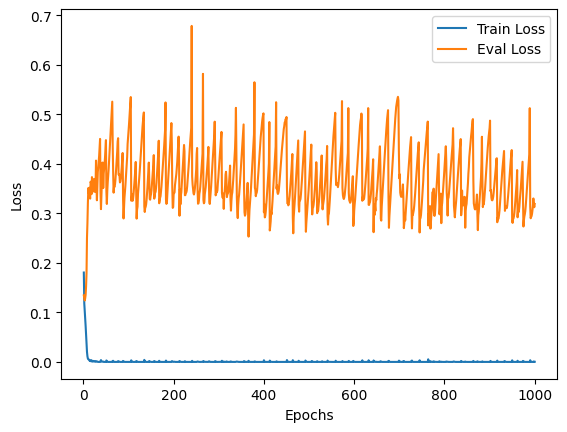

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(1, n_epoch + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epoch + 1), test_losses, label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[[16081   329]
 [  411  4807]]


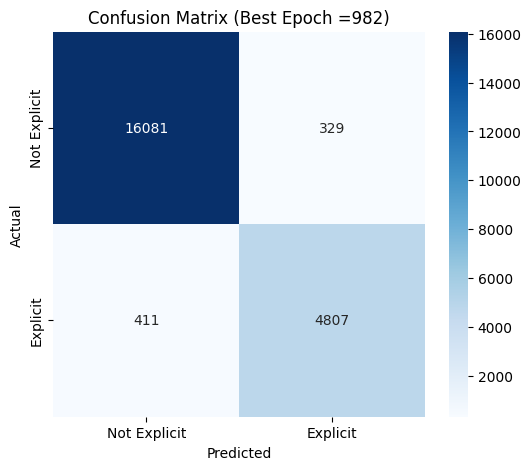

Accuracy:  0.9658
Precision: 0.9359
Recall:    0.9212
F1-score:  0.9285


In [10]:
cm = confusion_matrix(best_labels, best_pred)

plt.figure(figsize=(6,5))
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Explicit', 'Explicit'],
            yticklabels=['Not Explicit', 'Explicit']
            )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Best Epoch ={best_ephoc})')
plt.show()

acc = accuracy_score(best_labels, best_pred)
prec = precision_score(best_labels, best_pred )
rec = recall_score(best_labels, best_pred)
f1 = f1_score(best_labels, best_pred)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

In [11]:
end_time = time.time()  # Marcar fin
elapsed_time = end_time - start_time

print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")

Tiempo total de entrenamiento: 3641.33 segundos
